<a href="https://colab.research.google.com/github/InterstellarMist/VIP-Workshop-2024/blob/main/RadonTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ship detection

This is the script that will be used for identifying ship from ship wakes determined using Radon transform of Sentinel-1 SAR images enhanced by traditional image processing techniques.

Install and run the necessary packages for this module.

In [ ]:
# Run this cell at the beginning
!pip install rasterio
!pip install matplotlib-scalebar
!pip install geodatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 14.9 MB/s eta 0:00:00


In [ ]:
from skimage.transform import (hough_line, hough_line_peaks)
from skimage.transform import radon
from skimage.feature import peak_local_max

import numpy as np
import cv2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FormatStrFormatter

# Import necessary packages for reading tiff images
import rasterio as rs
from rasterio.plot import show, plotting_extent

import geopandas as gpd
from geodatasets import get_path
from shapely.geometry.point import Point


Mount Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Visualize raster to be processed.

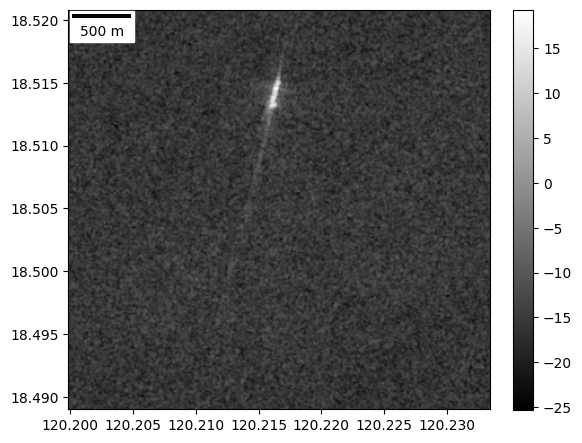

In [ ]:
# Reading TIFF files for further processing later
raster = rs.open('/content/drive/MyDrive/samples/shipwake0_db.tif')
array = raster.read(1)
extent_raster = plotting_extent(raster)

# Locate center points in the image for calibration
clong, clat = np.average(extent_raster[0:2]), np.average(extent_raster[2:4])

# For the plot scale bar
points = gpd.GeoSeries(
    [Point(clong, clat), Point(clong + 1, clat)], crs=4326
)
# one longitude difference on the same latitude in Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

nybb = gpd.read_file(get_path("nybb"))
nybb = nybb.to_crs(4326)  # Using geographic WGS 84

# ax = nybb.plot()
fig, ax = plt.subplots(1, figsize=(8, 8))
# nybb.plot(ax=ax)
plt.imshow(array, extent = extent_raster, cmap='gray')
# plt.imshow(array, cmap='gray')
plt.colorbar(fraction=0.043, pad=0.05)
ax.add_artist(ScaleBar(distance_meters,location="upper left"))
# plt.plot(179,75, '*r')

# Set x-axis and y-axis tick values to three digits
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))

Reduce the noise in the image using Median Filtering and enhance the linear features in the image to isolate ship wakes by Canny edge detection.

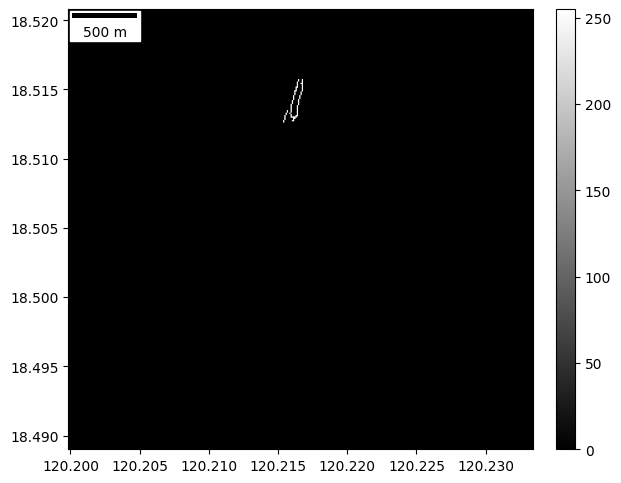

In [ ]:
def enhance_contrast(image, kernel_size, th1, th2):
  tiff_img = image

  # Convert 32-bit float image to 8-bit uint image
  grayscale = cv2.convertScaleAbs(tiff_img-np.amin(tiff_img), alpha=255.0 / (np.amax(tiff_img)-np.amin(tiff_img)))

  # Median blurring 5x5 kernel
  median = cv2.medianBlur(grayscale, kernel_size)

  th_1 = ((th1 - np.amin(tiff_img)) * 255.0) / (np.amax(tiff_img)-np.amin(tiff_img))
  th_2 = ((th2 -np.amin(tiff_img))* 255.0) / (np.amax(tiff_img)-np.amin(tiff_img))

  # Canny edge detection
  canny = cv2.Canny(median,threshold1 = th_2, threshold2 = th_1)

  return canny

# Obtain the contrast-enhanced image
enhanced = enhance_contrast(array, kernel_size=5, th1=-0.1, th2=0.1)

fig, ax = plt.subplots(1, figsize=(6, 6))

plt.imshow(enhanced, extent = extent_raster ,cmap = 'gray')

ax.add_artist(ScaleBar(distance_meters,location="upper left"))

# Set x-axis and y-axis tick values to three digits
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))

# Extract the mappable (ScalarMappable) from the plot
mappable = ax.get_children()[0]

# Create an inset axes for the colorbar
cax = ax.inset_axes([1.05, 0, 0.04, 1])

# Add colorbar to the inset axes using the mappable
cbar = plt.colorbar(mappable, cax=cax)

This part performs the Radon transform on the enhanced image and detect the peaks of the sinogram which could represent the ship wakes or linear features in the image.


In [ ]:
def detect_lines(image, min_distance, rel_threshold):
  # Generate theta for Radon transform - same size with the longer end of the image
  theta = np.linspace(0., 180., max(image.shape), endpoint=False)

  # Take the Radon transform of the enhanced image
  sinogram = radon(image, theta=theta)

  # Normalize sinogram
  n_sinogram = sinogram/np.amax(sinogram)

  # Detect peaks and assign peak coordinates as the container for the indices
  peak_coordinates = peak_local_max(sinogram,
                                    min_distance = min_distance,
                                    threshold_rel = rel_threshold)

  # Obtain the angle with the peaks in the sinogram
  theta_peak = theta[peak_coordinates[:,1]]

  # Take the location where the peak is located in the longitude
  long_peak_idx = sinogram.shape[0] - peak_coordinates[:,0]

  return n_sinogram, theta, theta_peak, long_peak_idx

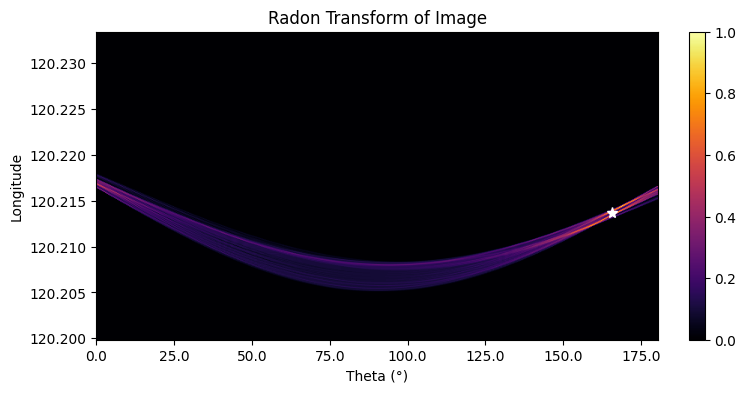

[165.56149733] [145] 1


In [ ]:
# Raster extent
extent_prime = plotting_extent(raster)

# Detect peaks using the function
n_sinogram, theta, theta_peak, long_peak_idx = detect_lines(enhanced,
                                                            min_distance=10,
                                                            rel_threshold=0.70)
# Determine number of peaks
num_peaks = len(theta_peak)

# Longitude prime in sinogram
lon_prime = np.linspace(extent_prime[0], extent_prime[1], raster.shape[0])

# Latitude array within limits in image
lat_prime = np.linspace(extent_prime[2], extent_prime[3], raster.shape[0])

# Peak values of longitude
long_peak = lon_prime[long_peak_idx]

fig, ax = plt.subplots(1, figsize=(8, 4))

plt.imshow(n_sinogram, cmap='inferno',
                 extent = [theta[0], theta[-1]+1, extent_prime[0], extent_prime[1]],
                #  extent = (theta[0], theta[-1]+1, 0, n_sinogram.shape[0]),
                 aspect='auto')
plt.ylim([extent_prime[0], extent_prime[1]])
cbar2 = plt.colorbar(ax=ax, fraction=0.044, pad=0.05)

# Plot peak point/s
plt.plot(theta_peak, long_peak, 'w*', markersize=8)

ax.set_title("Radon Transform of Image")

# Set axis labels
ax.set_xlabel(f"Theta (\N{DEGREE SIGN})")
ax.set_ylabel("Longitude")

# Set x-axis and y-axis tick values to three digits
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))

plt.show()

print(theta_peak, long_peak_idx, num_peaks)

Now that we have located the peak values, we can now trace the ship wakes on the image.

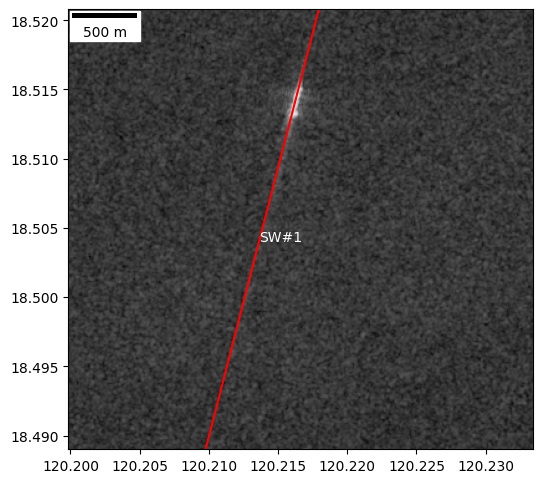

In [ ]:
# Set up figure properties
fig, ax = plt.subplots(1, figsize=(6, 6))

plt.imshow(array, extent = extent_raster, cmap='gray')
# plt.colorbar(fraction=0.043, pad=0.05)
ax.add_artist(ScaleBar(distance_meters,location="upper left"))

# Set x-axis and y-axis tick values to three digits
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))

# These are the x- and/or y-coordinates at image bounds
y_intercepts = []
x_intercepts = []

# Initialize counter for iterations in the for loop
iter_counter = 0

for angle, lon in zip(theta_peak, long_peak_idx):

    iter_counter = iter_counter + 1

    # Convert theta to radians
    angle = np.radians(angle)

    # Image center assuming image is in Quadrant IV
    x0, y0 = (raster.shape[1]-1) / 2, -(raster.shape[0]-1) / 2
    slope=np.tan(angle + np.pi/2)

    # Calculate the shift from the center of the rotated axis
    dy = abs(lon-x0) * np.tan(angle)

    # Locate the shifted centers
    xshift, yshift = lon, y0 + dy

    # Convert x0 and y0 to real world coordinates
    long0, lat0 = lon_prime[int(xshift)], lat_prime[int(yshift)]

    # For the line profile, we obtain the intercepts
    # We assume that the image is located at Quadrant IV y < 0, x > 0
    b0 = int(yshift - slope * xshift)

    # y-value at maximum x
    b1 = int(b0 + slope * raster.shape[1]-1)
    y_intercepts.append([b0, b1])
    # y_intercepts = [b0, b1]

    a0 = int((0 - b0)/slope)
    a1 = int((-raster.shape[0] - b0)/slope)
    x_intercepts.append([a0, a1])
    # x_intercepts = [a0, a1]

    # Plot line defining shipwake
    ax.axline((long0, lat0), slope=slope,color = 'r')
    ax.annotate('SW#%d'%iter_counter,(long0, lat0),xytext = (long0, lat0), color = 'w')

plt.show()

Determine which image bound/edge to take the line profile of the image.

In [ ]:
def remove_out_of_bounds_points(points, image_shape):
  """
  Checks if points are within image bounds and removes those outside.

  Args:
      points: NumPy array of shape (n, 2) where each row represents (x, y) coordinates.
      image_shape: Tuple representing the image shape (height, width).

  Returns:
      A NumPy masked array with Boolean values -if the point is within bounds or not.
  """

  # Extract image height and width
  image_height, image_width = image_shape

  # Create a mask with True for valid points and False for out-of-bounds
  mask = (points[0, :] >= 0) & (points[0, :] < image_width) & (points[1, :] >= 0) & (points[1, :] < image_height)

  return mask

In [ ]:
def line_profile(image, point1, point2):
    # Generate the line coordinates
    x1, y1 = point1
    x2, y2 = point2
    line_indices = np.linspace(0, 1, max(image.shape), endpoint=False)
    xs = (1 - line_indices) * x1 + line_indices * x2
    ys = (1 - line_indices) * y1 + line_indices * y2
    xs = np.round(xs).astype(int)
    ys = np.round(ys).astype(int)

    # Extract the line profile
    profile = image[ys, xs]

    # Find the peak position
    peak_value = np.max(profile)
    peak_index = np.argmax(profile)

    # Calculate the peak position along the line
    peak_position = (xs[peak_index], ys[peak_index])

    return profile, peak_value, peak_position


[[120.21649360997301, 18.51467933226778]]


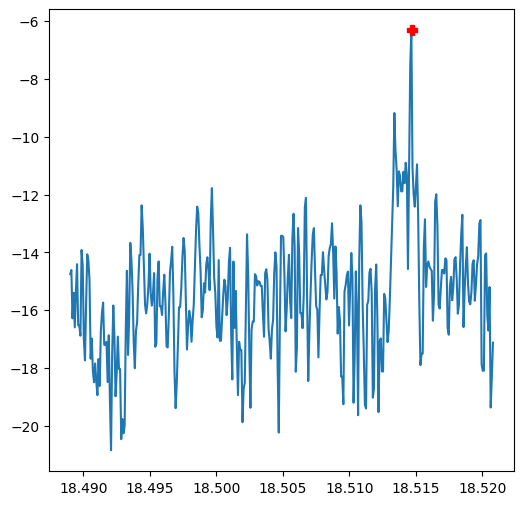

In [ ]:
# Initialize number of iterations
iter=0

fig, ax = plt.subplots(1, figsize=(6, 6))

# Extract image height and width
image_height, image_width = raster.shape

# Create a list to store points for each set of x_bounds
all_points_list = []
profile_bounds_list = []
peaks = []

for x_int, y_int in zip(x_intercepts, y_intercepts):
  iter+=1
  xint_coords = np.array([x_int,[0, image_height-1]]).reshape(2,-1)
  yint_coords = np.array([[0, image_width-1], y_int]).reshape(2,-1)

  # Concatenate points_x and points_y, and append to the list
  all_points = np.concatenate((xint_coords, yint_coords), axis=1)
  all_points_list.append(all_points)

  # Removes points/coordinates outside image bounds
  mask = remove_out_of_bounds_points(all_points, raster.shape)

  # Determine where the line hits image bounds for profile
  profile_bounds = all_points[:, mask]
  profile_bounds_list.append(profile_bounds)

  # Take the line profile across points along the image bounds
  profile, peak_val, peak_position = line_profile(array, profile_bounds[:,0],
                                                    profile_bounds[:,1])

  # Fill in the peak locations in geographic coordinates
  peaks.append([lon_prime[peak_position[0]], lat_prime[-peak_position[1]-1]])

  # Generate vector for axis assignment within the plot
  lat_ax = np.linspace(lat_prime[profile_bounds[1,1]],
                       lat_prime[profile_bounds[1,0]],
                       profile.size)
  print(peaks)
  ax.plot(lat_ax, profile)
  ax.plot(lat_prime[-peak_position[1]-1],
          peak_val, marker='P', color='red', markersize=7)



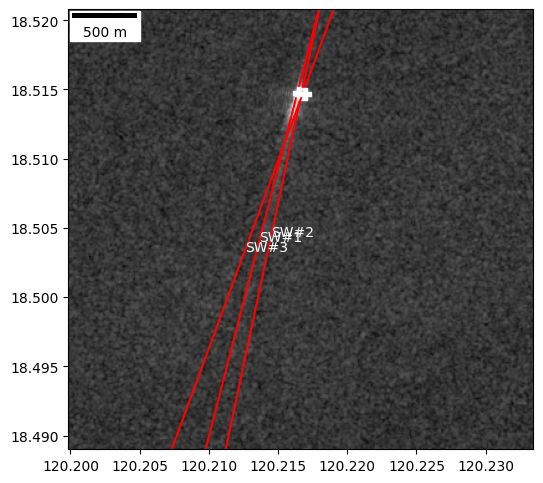

In [ ]:
# Set up figure properties
fig, ax = plt.subplots(1, figsize=(6, 6))

plt.imshow(array, extent = extent_raster, cmap='gray')
# plt.colorbar(fraction=0.043, pad=0.05)
ax.add_artist(ScaleBar(distance_meters,location="upper left"))

# Set x-axis and y-axis tick values to three digits
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))

# Initialize counter for iterations in the for loop
iter_counter = 0

for angle, lon, peak in zip(theta_peak, long_peak_idx, peaks):

    iter_counter = iter_counter + 1

    # Convert theta to radians
    angle = np.radians(angle)

    # Image center assuming image is in Quadrant IV
    x0, y0 = (raster.shape[1]-1) / 2, -(raster.shape[0]-1) / 2
    slope=np.tan(angle + np.pi/2)

    # Calculate the shift from the center of the rotated axis
    dy = abs(lon-x0) * np.tan(angle)

    # Locate the shifted centers
    xshift, yshift = lon, y0 + dy

    # Convert x0 and y0 to real world coordinates
    long0, lat0 = lon_prime[int(xshift)], lat_prime[int(yshift)]

    longpk, latpk = lon_prime[int(xshift)], lat_prime[int(yshift)]

    # Plot line defining shipwake
    ax.axline((long0, lat0), slope=slope,color = 'r')
    ax.plot(peak[0], peak[1], marker='P', color='white', markersize=8)
    ax.annotate('SW#%d'%iter_counter,(long0, lat0),xytext = (long0, lat0), color = 'w')

plt.show()

In [ ]:
# Shape[0] - rows y, shape[1] - column
# raster.shape
# y_lin.shape, line_profile.shape
lat_prime.size, x_bounds, y_lims, array.shape, extent_prime

(374,
 [[193, 101]],
 (0, 353),
 (354, 374),
 (120.19983787758049,
  120.23343486920656,
  18.489004819798993,
  18.520805180856822))

In [ ]:
lat_prime[-71]

18.51483728467975

120.21649360997301 18.51476941827644


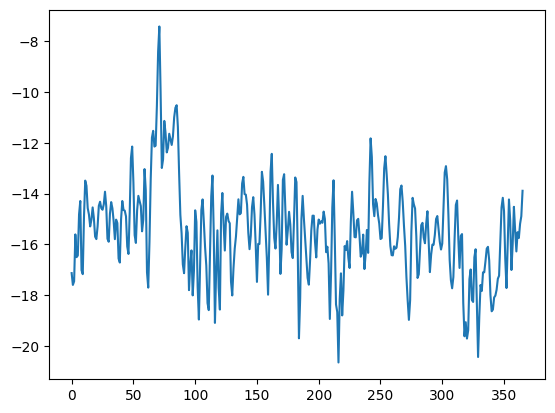

In [ ]:
# from re import X
from skimage.measure import profile_line

line_profile = profile_line(array, (profile_bounds_array[0][:,0][1], profile_bounds_array[0][:,0][0]),
                             (profile_bounds_array[0][:,1][1], profile_bounds_array[0][:,1][0]))


max_val = max(line_profile)
max_index = np.where(line_profile == max_val)

x_lin = np.linspace(profile_bounds_array[0][:,0][0],profile_bounds_array[0][:,1][0], line_profile.size)
y_lin = np.linspace(profile_bounds_array[0][:,0][1],profile_bounds_array[0][:,1][1], line_profile.size)

long_loc = lon_prime[int(x_lin[max_index[0][0]])]
lat_loc = lat_prime[int(-y_lin[max_index[0][0]])]

plt.plot(line_profile)

print(long_loc, lat_loc)

# Function

Inputs image, outputs the identified ship coordinates in lat-long coordinates, number of peaks/ships.

Functions to build:

1.   Contrast enhancement of the line features within the image
2.   Take the Radon transform and detect lines within the image
3.   Determine the points for the line profile
4.   Take the line profile with the identified brightest pixel as the ship coordinate




In [ ]:
def enhance_contrast(image, kernel_size, th1, th2):
  """
  Checks if points are within image bounds and removes those outside.

  Args:
      image: image to be processed
      kernel_size: size of the median filter for median blurring
      th1: lower limit for hystersis thresholding in Canny edge detection
      th2: upper limit for hystersis thresholding in Canny edge detection

  Returns:
      A binary image with traces of line features in the raster.
  """

  # Read image
  tiff_img = image

  # Convert 32-bit float image to 8-bit uint image
  grayscale = cv2.convertScaleAbs(tiff_img-np.amin(tiff_img), alpha=255.0 / (np.amax(tiff_img)-np.amin(tiff_img)))

  # Median blurring 5x5 kernel
  median = cv2.medianBlur(grayscale, kernel_size)

  th_1 = ((th1 - np.amin(tiff_img)) * 255.0) / (np.amax(tiff_img)-np.amin(tiff_img))
  th_2 = ((th2 -np.amin(tiff_img))* 255.0) / (np.amax(tiff_img)-np.amin(tiff_img))

  # Canny edge detection
  canny = cv2.Canny(median,threshold1 = th_2, threshold2 = th_1)

  return canny

In [ ]:
def detect_lines(image, min_distance, rel_threshold):
  """
  Checks if points are within image bounds and removes those outside.

  Args:
      image: Image to be processed (Contrast-enhanced image)
      min_distance: Minimum distance of peaks
      rel_threshold: The minimum threshold relative to the brightest in the image

  Returns:
      n_sinogram: normalized sinogram after Radon transform of image
      theta: theta values in Radon transform
      theta_peak: This is the peak theta value/s
      long_peak_idx: The location of peak/s in terms of index/indices
  """

  # Generate theta for Radon transform
  theta = np.linspace(0., 180., max(image.shape), endpoint=False)

  # Take the Radon transform of the enhanced image
  sinogram = radon(image, theta=theta)

  # Normalize sinogram
  n_sinogram = sinogram/np.amax(sinogram)

  # Detect peaks and assign peak coordinates as the container for the indices
  peak_coordinates = peak_local_max(sinogram, min_distance = min_distance, threshold_rel = rel_threshold)

  # Obtain the angle with the peaks in the sinogram
  theta_peak = theta[peak_coordinates[:,1]]

  # Take the location where the peak is located in the longitude
  long_peak_idx = sinogram.shape[0] - peak_coordinates[:,0]

  return n_sinogram, theta, theta_peak, long_peak_idx


In [ ]:
def remove_out_of_bounds_points(points, image_shape):
  """
  Checks if points are within image bounds and removes those outside.

  Args:
      points: NumPy array of shape (n, 2) where each row represents (x, y) coordinates.
      image_shape: Tuple representing the image shape (height, width).

  Returns:
      A NumPy masked array with Boolean values -if the point is within bounds or not.
  """

  # Extract image height and width
  image_height, image_width = image_shape

  # Create a mask with True for valid points and False for out-of-bounds
  mask = (points[0, :] >= 0) & (points[0, :] < image_width) & (points[1, :] >= 0) & (points[1, :] < image_height)

  return mask

In [ ]:
# def ship_coords()
image

# Trace the image bounds
x_lims, y_lims = (0,raster.shape[1] - 1), (0,raster.shape[0] - 1)

# Create a list to store points for each set of x_bounds
all_points_list = []
profile_bounds_list = []

for x_bound, y_bound in zip(x_bounds, y_bounds):
  # Retain the original logic for points_x and points_y with the current x_bound
  points_x = np.concatenate((x_bound, y_lims)).reshape(2, 2)
  points_y = np.concatenate((x_lims, y_bound)).reshape(2, 2)

  # Concatenate points_x and points_y, and append to the list
  all_points = np.concatenate((points_x, points_y), axis=1)
  all_points_list.append(all_points)

  # Removes points/coordinates outside image bounds
  mask = remove_out_of_bounds_points(all_points, raster.shape)

  # Determine where the line hits image bounds for profile
  profile_bounds = all_points[:,mask]
  profile_bounds_list.append(profile_bounds)

# Combine all points into a multidimensional array with layers
all_points_array = np.stack(all_points_list)

# Combine profile bounds into a multidimensional array with layers
profile_bounds_array = np.stack(profile_bounds_list)